In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Data import

In [2]:
chembl_32 = pd.read_excel('ChEMBL_32_documents.xlsx', sheet_name='Sheet1').drop_duplicates(subset='document_chembl_id')

In [3]:
data_chembl = pd.read_csv('ChEMBL_reference.csv', sep=',')
data_chembl = data_chembl.drop_duplicates(subset='document_chembl_id').reset_index(drop=True)

In [4]:
chembl_32_merged = pd.merge(chembl_32, data_chembl, how='left')
data_chembl_core = chembl_32_merged.dropna(subset='PUBMED_TYPE')

In [5]:
core_journals = ['ACS Med Chem Lett', 'Bioorg Med Chem', 'Bioorg Med Chem Lett', 'Eur J Med Chem', 'J Med Chem',
                 'J Nat Prod', 'Medchemcomm']
data_chembl_core = data_chembl_core[data_chembl_core['journal'].isin(core_journals)].reset_index(drop=True)
data_chembl_unclass = pd.concat([chembl_32_merged, data_chembl_core], axis=0).drop_duplicates(keep=False).reset_index(
    drop=True)

In [6]:
data_from_pubmed = pd.read_excel('data_from_pubmed.xlsx', sheet_name='core journals').drop_duplicates(
    subset='PMID').reset_index(drop=True)
data_from_pubmed_refs = pd.read_csv('pubmed_reference.csv', sep=',')
data_from_pubmed = pd.concat([data_from_pubmed, data_from_pubmed_refs], axis=1)

# Data preprocessing (pubmed data)

In [7]:
abstracts_pubmed = pd.read_excel('abstracts_pubmed.xlsx', sheet_name='abstracts')
abstracts_pubmed = abstracts_pubmed.iloc[:, 0]
data_from_pubmed['abstract'] = abstracts_pubmed

In [8]:
data_from_pubmed_main = data_from_pubmed[
    ['PMID', 'Publication Year', 'Authors', 'page1', 'page2', 'Journal/Book', 'reference', 'Title', 'abstract',
     'pubtype ']]

unique_journals = data_from_pubmed_main['Journal/Book'].unique()
for journal in unique_journals:
    data_from_pubmed_main['journal_' + str(journal)] = data_from_pubmed_main['Journal/Book'] == journal

data_from_pubmed_main.replace(True, 1, inplace=True)
data_from_pubmed_main.replace(False, 0, inplace=True)

In [9]:
data_from_pubmed_main['pages'] = data_from_pubmed_main['page2'] - data_from_pubmed_main['page1']

auth_num = []
auth = data_from_pubmed_main['Authors'].values

for string in auth:
    auth_num.append(str(string).count(',') + 1)
data_from_pubmed_main['auth_num'] = np.array(auth_num)

In [10]:
pubmed_data = {'pubmed_id': data_from_pubmed_main['PMID'].values,
               'pages': np.log(data_from_pubmed_main.pages.values + 1),
               'year': data_from_pubmed_main['Publication Year'].values,
               'auth_num': np.log(data_from_pubmed_main.auth_num.values + 1),
               'reference': np.log(data_from_pubmed_main.reference.values + 1),
               'journal_Medchemcomm': data_from_pubmed_main['journal_Medchemcomm'].values,
               'journal_J Nat Prod': data_from_pubmed_main['journal_J Nat Prod'].values,
               'journal_J Med Chem': data_from_pubmed_main['journal_J Med Chem'].values,
               'journal_Eur J Med Chem': data_from_pubmed_main['journal_Eur J Med Chem'].values,
               'journal_Bioorg Med Chem Lett': data_from_pubmed_main['journal_Bioorg Med Chem Lett'].values,
               'journal_Bioorg Med Chem': data_from_pubmed_main['journal_Bioorg Med Chem'].values,
               'journal_ACS Med Chem Lett': data_from_pubmed_main['journal_ACS Med Chem Lett'].values,}

pubmed_df = pd.DataFrame(pubmed_data)

In [11]:
data_chembl_core_main = data_chembl_core[
    ['pubmed_id', 'year', 'authors', 'first_page', 'last_page', 'journal', 'references', 'title', 'abstract',
     'PUBMED_TYPE']]
data_chembl_unclass_main = data_chembl_unclass[
    ['pubmed_id', 'year', 'authors', 'first_page', 'last_page', 'journal', 'references', 'title', 'abstract',
     'PUBMED_TYPE']]

In [12]:
for journal in unique_journals:
    data_chembl_core_main['journal_' + str(journal)] = data_chembl_core_main['journal'] == journal
    data_chembl_unclass_main['journal_' + str(journal)] = data_chembl_unclass_main['journal'] == journal
data_chembl_core_main.replace(True, 1, inplace=True)
data_chembl_core_main.replace(False, 0, inplace=True)
data_chembl_unclass_main.replace(True, 1, inplace=True)
data_chembl_unclass_main.replace(False, 0, inplace=True)

In [13]:
data_chembl_core_main['pages'] = data_chembl_core_main['last_page'] - data_chembl_core_main['first_page']

auth_num = []
auth = data_chembl_core_main['authors'].values

for string in auth:
    auth_num.append(str(string).count(',') + 1)
data_chembl_core_main['auth_num'] = np.array(auth_num)

In [14]:
data_chembl_unclass_main['pages'] = data_chembl_unclass_main['last_page'] - data_chembl_unclass_main['first_page']

auth_num = []
auth = data_chembl_unclass_main['authors'].values

for string in auth:
    auth_num.append(str(string).count(',') + 1)
data_chembl_unclass_main['auth_num'] = np.array(auth_num)

In [15]:
chembl_core_data = {'pubmed_id': data_chembl_core_main['pubmed_id'].values,
                    'pages': np.log(data_chembl_core_main.pages.values + 1),
                    'year': data_chembl_core_main['year'].values,
                    'auth_num': np.log(data_chembl_core_main.auth_num.values + 1),
                    'reference': np.log(data_chembl_core_main.references.values + 1),
                    'journal_Medchemcomm': data_chembl_core_main['journal_Medchemcomm'].values,
                    'journal_J Nat Prod': data_chembl_core_main['journal_J Nat Prod'].values,
                    'journal_J Med Chem': data_chembl_core_main['journal_J Med Chem'].values,
                    'journal_Eur J Med Chem': data_chembl_core_main['journal_Eur J Med Chem'].values,
                    'journal_Bioorg Med Chem Lett': data_chembl_core_main['journal_Bioorg Med Chem Lett'].values,
                    'journal_Bioorg Med Chem': data_chembl_core_main['journal_Bioorg Med Chem'].values,
                    'journal_ACS Med Chem Lett': data_chembl_core_main['journal_ACS Med Chem Lett'].values}

chembl_core_df = pd.DataFrame(chembl_core_data)

In [16]:
chembl_unclass_data = {'pubmed_id': data_chembl_unclass_main['pubmed_id'].values,
                       'pages': np.log(data_chembl_unclass_main.pages.values + 1),
                       'year': data_chembl_unclass_main['year'].values,
                       'auth_num': np.log(data_chembl_unclass_main.auth_num.values + 1),
                       'reference': np.log(data_chembl_unclass_main.references.values + 1),
                       'journal_Medchemcomm': data_chembl_unclass_main['journal_Medchemcomm'].values,
                       'journal_J Nat Prod': data_chembl_unclass_main['journal_J Nat Prod'].values,
                       'journal_J Med Chem': data_chembl_unclass_main['journal_J Med Chem'].values,
                       'journal_Eur J Med Chem': data_chembl_unclass_main['journal_Eur J Med Chem'].values,
                       'journal_Bioorg Med Chem Lett': data_chembl_unclass_main['journal_Bioorg Med Chem Lett'].values,
                       'journal_Bioorg Med Chem': data_chembl_unclass_main['journal_Bioorg Med Chem'].values,
                       'journal_ACS Med Chem Lett': data_chembl_unclass_main['journal_ACS Med Chem Lett'].values}

chembl_unclass_df = pd.DataFrame(chembl_unclass_data)

In [17]:
pubmed_df['class'] = data_from_pubmed_main['pubtype '].values
chembl_core_df['class'] = data_chembl_core_main.PUBMED_TYPE.values
chembl_unclass_df['class'] = data_chembl_unclass_main.PUBMED_TYPE.values

pubmed_df['title'] = data_from_pubmed_main.Title.values
chembl_core_df['title'] = data_chembl_core_main.title.values
chembl_unclass_df['title'] = data_chembl_unclass_main.title.values

pubmed_df['abstract'] = data_from_pubmed_main.abstract.values
chembl_core_df['abstract'] = data_chembl_core_main.abstract.values
chembl_unclass_df['abstract'] = data_chembl_unclass_main.abstract.values

In [18]:
classified_df = pd.concat([pubmed_df, chembl_core_df], axis=0).drop_duplicates(subset='pubmed_id').reset_index(
    drop=True)

unique_class = classified_df['class'].unique()
for cl in unique_class:
    if cl == 'Review':
        classified_df['class'].replace(cl, 1, inplace=True)
    else:
        classified_df['class'].replace(cl, 0, inplace=True)

In [19]:
array_of_mistakes = np.array([26985286, 35059113, 35059117, 35178165, 35178167, 34606998, 35059114, 
                              35178166, 35059115, 35059116, 35178168, 35300084, 35300085])

chembl_unclass_df.loc[chembl_unclass_df['pubmed_id'].isin(array_of_mistakes), 'abstract'] = np.nan

# BERT vectorisation

In [20]:
classified_df['abstract'].fillna('[MASK]', inplace=True)
chembl_unclass_df['abstract'].fillna('[MASK]', inplace=True)

In [21]:
abstracts_X = list(classified_df['abstract'].values)
titles_X = list(classified_df['title'].values)
texts_X = [f"{t1}. {t2}" for t1, t2 in zip(titles_X, abstracts_X)]
pd.DataFrame(texts_X).to_csv('title_abstract_texts_X.csv', index=False)

In [22]:
all_abstracts = chembl_unclass_df.abstract.values
all_titles = chembl_unclass_df.title.values
all_texts = [f"{t1}. {t2}" for t1, t2 in zip(all_titles, all_abstracts)]
pd.DataFrame(all_texts).to_csv('title_abstract_texts_all.csv', index=False)

In [23]:
cls_X_matrix_pubmed = pd.read_csv('cls_X_matrix_pubmedbert.csv', sep=',')
cls_all_matrix_pubmed = pd.read_csv('cls_all_matrix_pubmedbert.csv', sep=',')

In [24]:
classified_df_vect_pubmed = pd.concat([classified_df, cls_X_matrix_pubmed], axis=1)
classified_df_vect_pubmed = classified_df_vect_pubmed.drop(columns=['title', 'abstract'])
classified_df_vect_pubmed.pages.replace(0, None, inplace=True)
classified_df_vect_pubmed.reference.replace(0, None, inplace=True)

In [25]:
unclassified_df_vect_pubmed = pd.concat([chembl_unclass_df, cls_all_matrix_pubmed], axis=1)
unclassified_df_vect_pubmed = unclassified_df_vect_pubmed.drop(columns=['title', 'abstract'])
unclassified_df_vect_pubmed.pages.replace(0, None, inplace=True)
unclassified_df_vect_pubmed.reference.replace(0, None, inplace=True)

# Figures

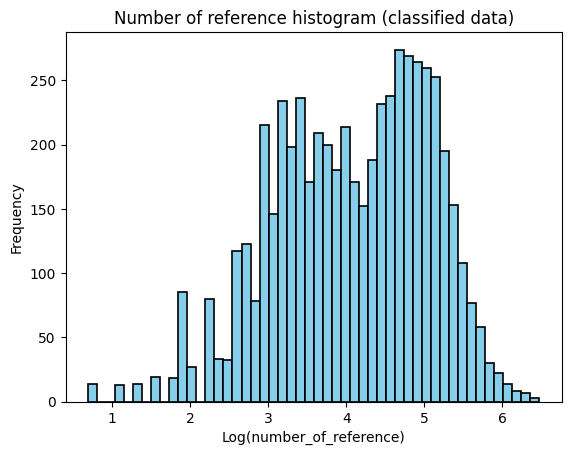

In [26]:
data = classified_df_vect_pubmed.reference.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Number of reference histogram (classified data)')
plt.xlabel('Log(number_of_reference)')
plt.ylabel('Frequency')
plt.savefig('Reference_histogram_classified_data.png', dpi=600)
plt.show()

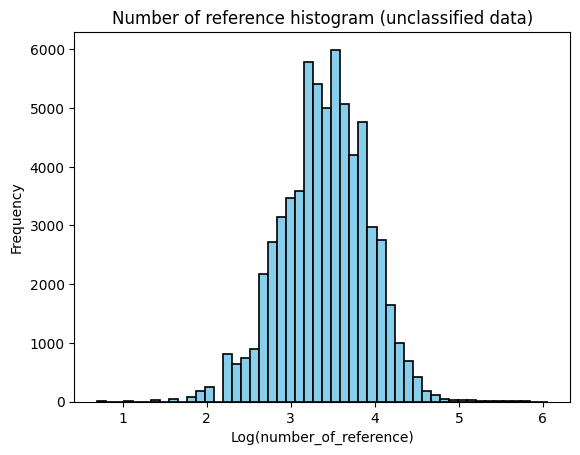

In [27]:
data = unclassified_df_vect_pubmed.reference.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Number of reference histogram (unclassified data)')
plt.xlabel('Log(number_of_reference)')
plt.ylabel('Frequency')
plt.savefig('Reference_histogram_unclassified_data.png', dpi=600)
plt.show()

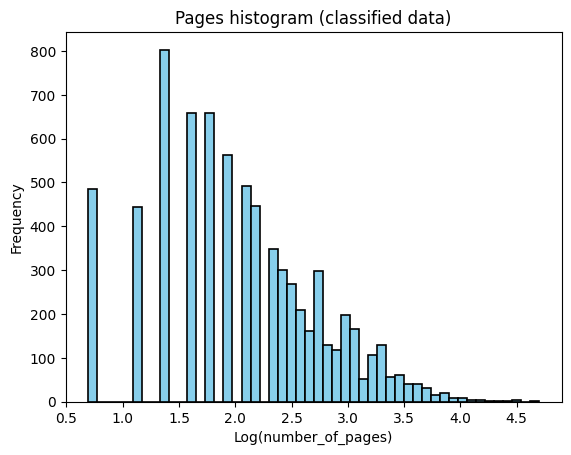

In [28]:
data = classified_df_vect_pubmed.pages.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Pages histogram (classified data)')
plt.xlabel('Log(number_of_pages)')
plt.ylabel('Frequency')
plt.savefig('Pages_histogram_classified_data.png', dpi=600)
plt.show()

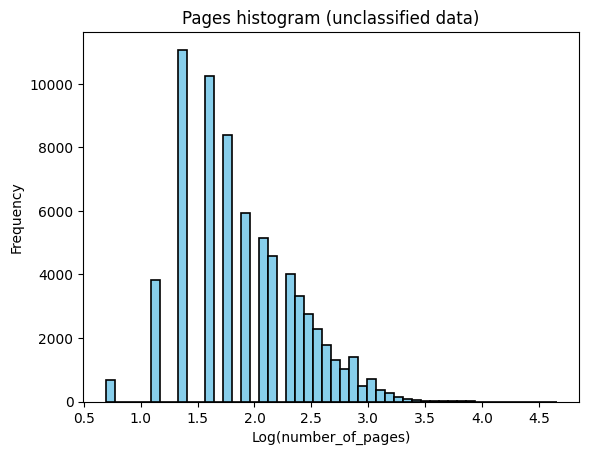

In [29]:
data = unclassified_df_vect_pubmed[unclassified_df_vect_pubmed['pages'] < 5].pages.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Pages histogram (unclassified data)')
plt.xlabel('Log(number_of_pages)')
plt.ylabel('Frequency')
plt.savefig('Pages_histogram_unclassified_data.png', dpi=600)
plt.show()

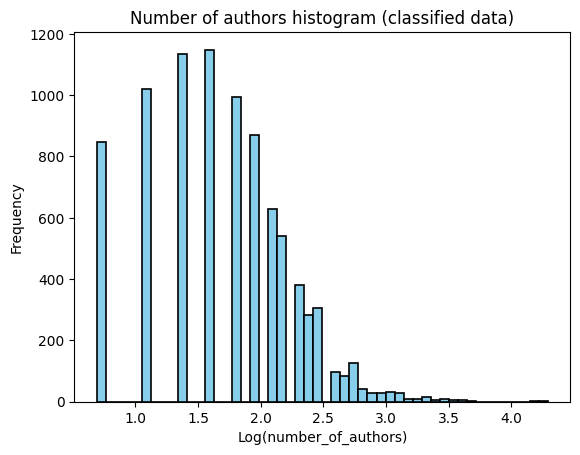

In [30]:
data = classified_df_vect_pubmed.auth_num.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Number of authors histogram (classified data)')
plt.xlabel('Log(number_of_authors)')
plt.ylabel('Frequency')
plt.savefig('Authors_histogram_classified_data.png', dpi=600)
plt.show()

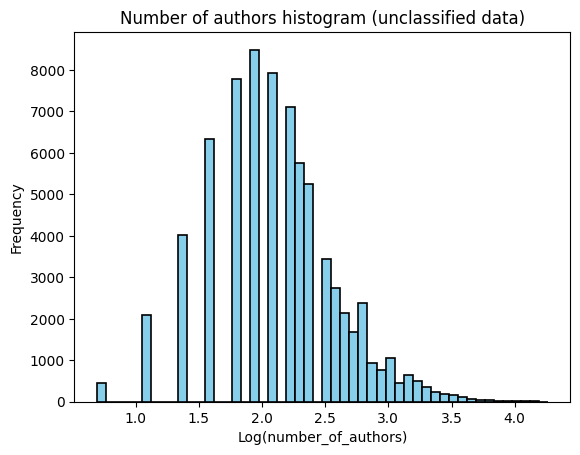

In [31]:
data = unclassified_df_vect_pubmed.auth_num.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Number of authors histogram (unclassified data)')
plt.xlabel('Log(number_of_authors)')
plt.ylabel('Frequency')
plt.savefig('Authors_histogram_unclassified_data.png', dpi=600)
plt.show()

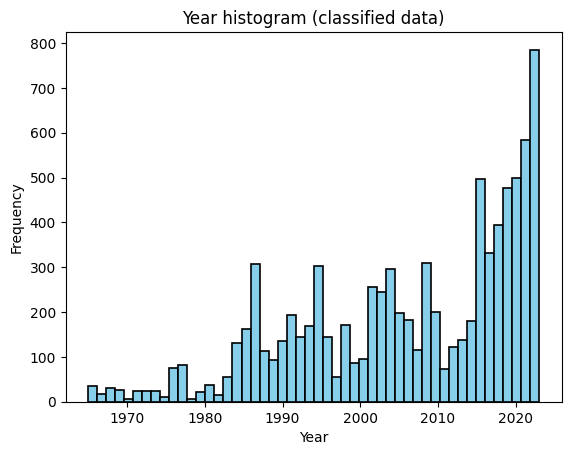

In [32]:
data = classified_df_vect_pubmed.year.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Year histogram (classified data)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig('Year_histogram_classified_data.png', dpi=600)
plt.show()

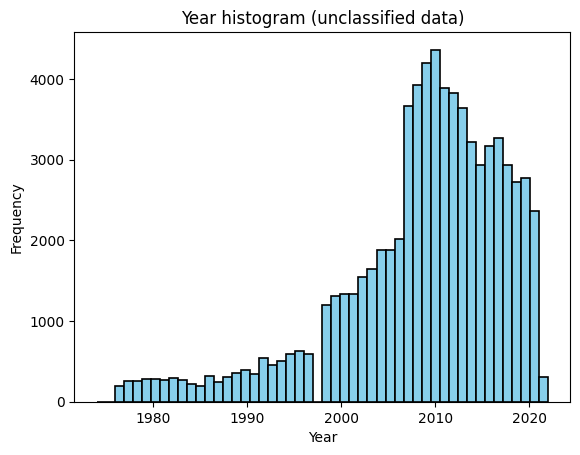

In [33]:
data = unclassified_df_vect_pubmed.year.dropna()

plt.hist(data, bins=50, edgecolor='black', color='skyblue', linewidth=1.2)

plt.title('Year histogram (unclassified data)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig('Year_histogram_unclassified_data.png', dpi=600)
plt.show()

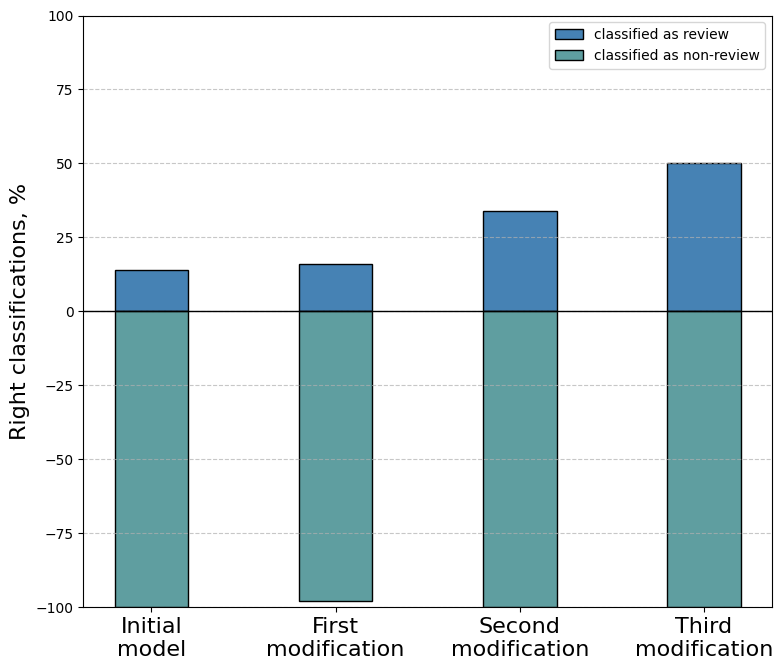

In [34]:
data1 = [7 / 50 * 100, 8 / 50 * 100, 17 / 50 * 100, 25 / 50 * 100]
data2 = [1 * 100, 49 / 50 * 100, 1 * 100, 1 * 100]
labels = ['Initial\nmodel', 'First\nmodification', 'Second\nmodification', 'Third\nmodification']

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 6.8))
ax.bar(x, data1, width=0.4, label='classified as review', color='steelblue', align='center', edgecolor='black')
ax.bar(x, [-d for d in data2], width=0.4, label='classified as non-review', color='cadetblue', align='center',
       edgecolor='black')
ax.set_ylabel('Right classifications, %', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend()
ax.axhline(0, color='black', linewidth=1)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(-100, 100)

plt.tight_layout()
plt.savefig('manual_curation_barplot.png', dpi=800)
plt.show()

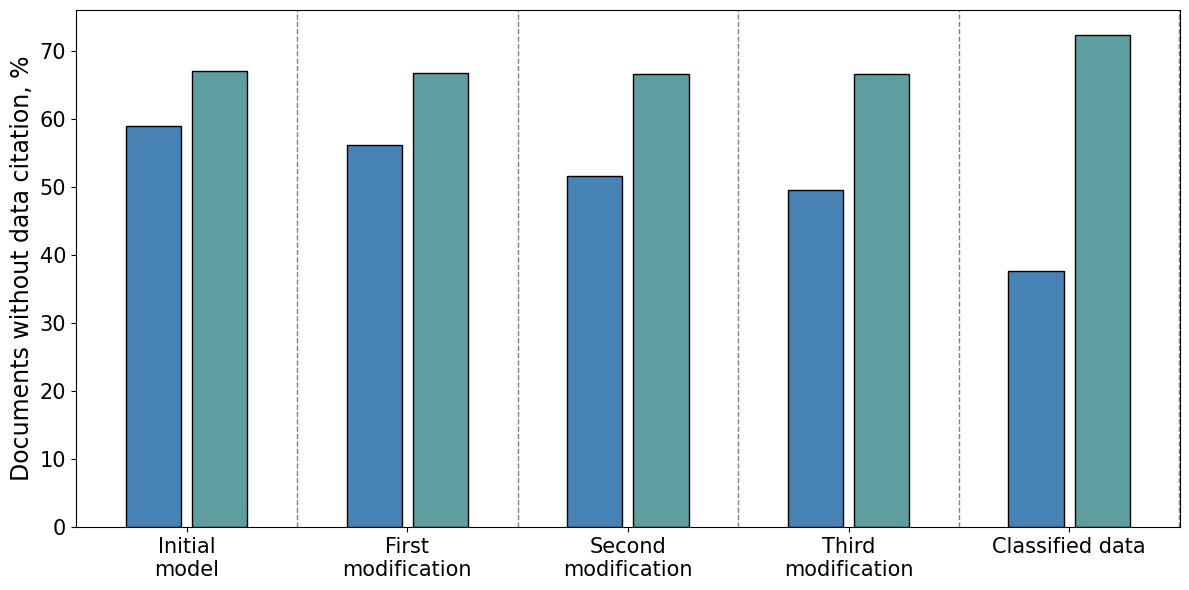

In [35]:
correct_values = [0.590057636887608 * 100, 0.5619295958279009 * 100, 0.5162064825930373 * 100,
                  0.49568221070811747 * 100, 0.37720848056537104 * 100]
incorrect_values = [0.6707535537305447 * 100, 0.6670393756029115 * 100, 0.666270783847981 * 100,
                    0.6656429200403772 * 100, 0.7240341194179629 * 100]

combined_values = [val for pair in zip(correct_values, incorrect_values) for val in pair]

labels = ['Initial\nmodel', 'First\nmodification', 'Second\nmodification', 'Third\nmodification', 'Classified data']
colors = ['sandybrown', 'chocolate', 'sandybrown', 'chocolate', 'sandybrown', 'chocolate', 'sandybrown', 'chocolate',
          'sandybrown', 'chocolate']

plt.figure(figsize=(12, 6))
x = np.arange(len(labels)) * 2
plt.bar(x - 0.3, correct_values, 0.5, color='steelblue', edgecolor='black')
plt.bar(x + 0.3, incorrect_values, 0.5, color='cadetblue', edgecolor='black')

for i in range(len(labels)):
    plt.axvline(x=i * 2 + 1, color='gray', linestyle='--', linewidth=1)

plt.ylabel('Documents without data citation, %', fontsize=17)
plt.xticks(x, labels, fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('citation_barplot.png', dpi=800)
plt.show()

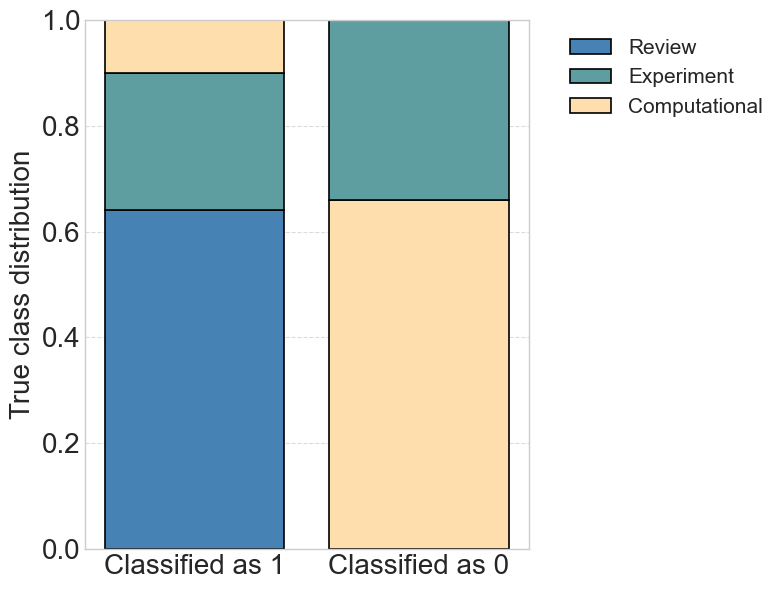

In [36]:
values_1 = [0.64, 0.26, 0.1]
values_2 = [0.66, 0.34, 0]

plt.style.use("seaborn-v0_8-whitegrid")

colors_1 = ['steelblue', 'cadetblue', 'navajowhite']
colors_2 = ['navajowhite', 'cadetblue', 'steelblue']

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(1, values_1[0], color=colors_1[0], label='Review', edgecolor='black', linewidth=1.2)
ax.bar(1, values_1[1], bottom=values_1[0], color=colors_1[1], label='Experiment', edgecolor='black', linewidth=1.2)
ax.bar(1, values_1[2], bottom=np.sum(values_1[:2]), color=colors_1[2], label='Computational', edgecolor='black',
       linewidth=1.2)

ax.bar(2, values_2[0], color=colors_2[0], edgecolor='black', linewidth=1.2)
ax.bar(2, values_2[1], bottom=values_2[0], color=colors_2[1], edgecolor='black', linewidth=1.2)
ax.bar(2, values_2[2], bottom=np.sum(values_2[:2]), color=colors_2[2], edgecolor='black', linewidth=1.2)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Classified as 1', 'Classified as 0'], fontsize=20)
ax.set_ylabel('True class distribution', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1.05, 1))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.savefig('barplot_pres.png', dpi=800)
plt.show()